In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

plt.rcParams["figure.figsize"] = (15,8)

# AR - Autoregressive Model

## 1) Load the data - IMPORTANT: remainder.csv!

In [2]:
df = pd.read_csv('flights_remainder.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,remainder
date,
1949-01-01,4.405303
1949-02-01,17.496212
1949-03-01,7.496212
1949-04-01,9.587121
1949-05-01,-5.231061


In [4]:
# Plot the data
def plot_remainder(df, title='Remaining Passenger Number after modelling Trend and Seasonality'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    plt.show()

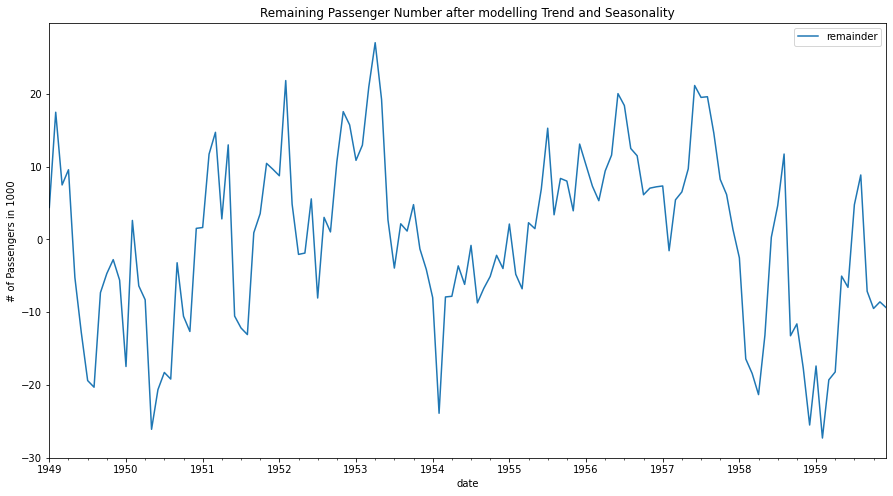

In [5]:
plot_remainder(df)

## 2) Create a time-lagged input feature: lag1

A lag is an interval of time between to related phenomena. The two related phenomena in this case are the remainder today and the remainder tomorrow.

In [6]:
df['lag1'] = df['remainder'].shift(1)
df.head()

,remainder,lag1
date,,
1949-01-01,4.405303,NaN
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121


## 3) Inspect correlations

<AxesSubplot:>

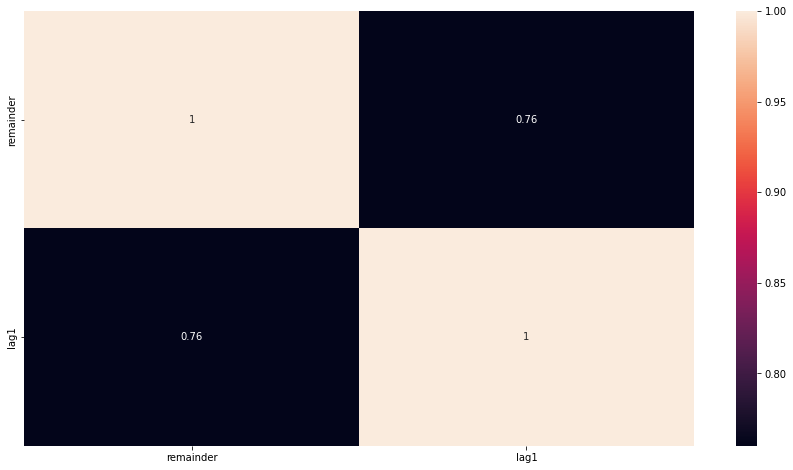

In [7]:
sns.heatmap(round(df.corr(), 2), annot=True)

#### Intuitively

- If it was warm yesterday, it is more likely to be warm today

- If a there were a lot of passengers last month we expect a lot of passengers this month

## 4) Plot remainder against lag1

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

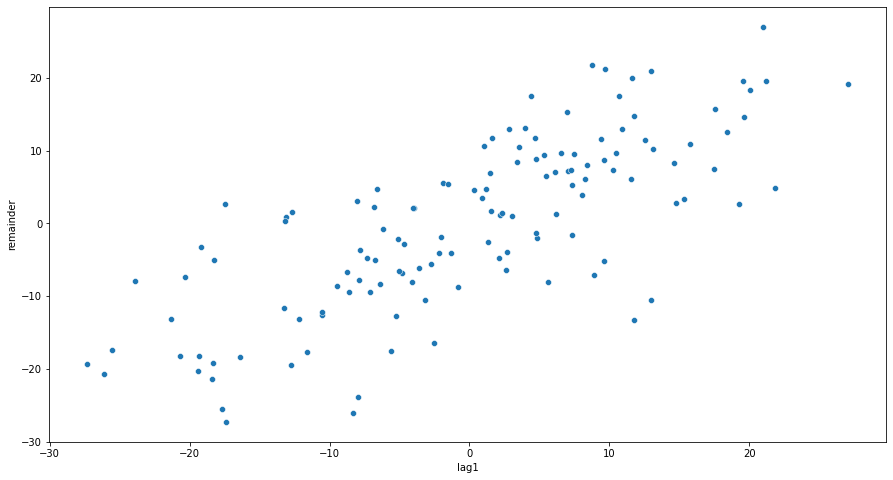

In [8]:
sns.scatterplot(x='lag1', y='remainder', data=df)

# AR - Autoregressive Model

Now we are ready to talk about the autoregressive model. In the autoregressive model we model the future value of a variable by looking at the present (and maybe past) value of the same variable. In our case the variable will be the **remainder**.

$$
y_{t+1} = w_0 + \sum_{j=0}^{P-1}w_{j+1}y_{t-j} + \epsilon_t
$$

where $t$ is the current timestep, $w_0$ is the bias/intercept, the w’s are the weights of the model and $\epsilon$ is some **iid** (e.g. Gaussian - more on this in the afternoon) noise. **P** is the number of lags to use for the model. It is a hyperparameter that we have to choose.

**AR(1) - Model**

$$
\hat{y}_{t+1} = w_0 + w_1 \cdot y_{t}
$$


In an AR(1) model we model the value in $t+1$ as a linear function of the value in $t$.

**AR(2) - Model**

$$
\hat{y}_{t+1} = w_0 + w_1 \cdot y_{t} + w_2 \cdot y_{t-1}
$$

# 5) Run an Autoregression (Linear Regression) of lag1 on the remainder

In [9]:
# Drop missing values
df.dropna(inplace=True)
df.head()

,remainder,lag1
date,,
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121
1949-06-01,-12.776515,-5.231061


In [10]:
# Assign X and y
X = df[['lag1']]
y = df['remainder']

In [11]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [12]:
# Create predictions
df['predictions_ar1'] = m.predict(X)
df.head()

,remainder,lag1,predictions_ar1
date,,,
1949-02-01,17.496212,4.405303,3.258369
1949-03-01,7.496212,17.496212,13.203025
1949-04-01,9.587121,7.496212,5.606413
1949-05-01,-5.231061,9.587121,7.194795
1949-06-01,-12.776515,-5.231061,-4.062003


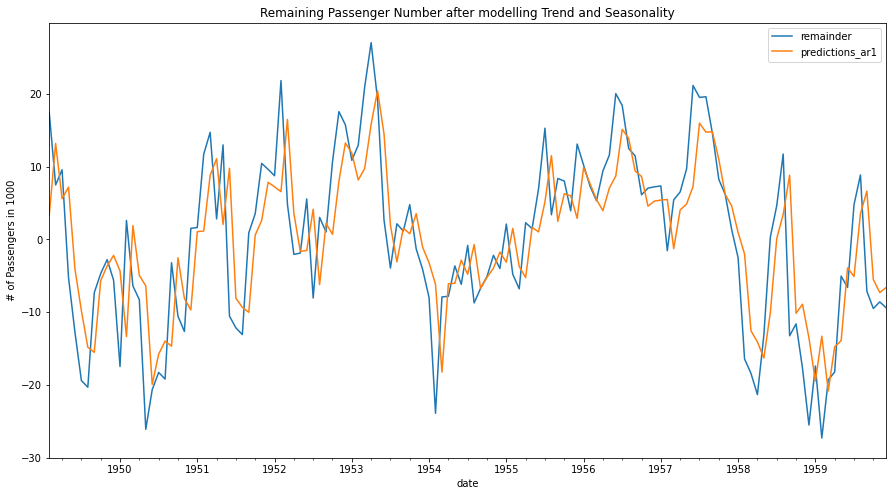

In [13]:
# Plot the original remainder and the prediction
plot_remainder(df[['remainder', 'predictions_ar1']])

# 6) Should we add lag2?

How could we find out?

In [14]:
df['lag2'] = df['remainder'].shift(2)
df.head()

,remainder,lag1,predictions_ar1,lag2
date,,,,
1949-02-01,17.496212,4.405303,3.258369,NaN
1949-03-01,7.496212,17.496212,13.203025,NaN
1949-04-01,9.587121,7.496212,5.606413,17.496212
1949-05-01,-5.231061,9.587121,7.194795,7.496212
1949-06-01,-12.776515,-5.231061,-4.062003,9.587121


<AxesSubplot:xlabel='lag2', ylabel='remainder'>

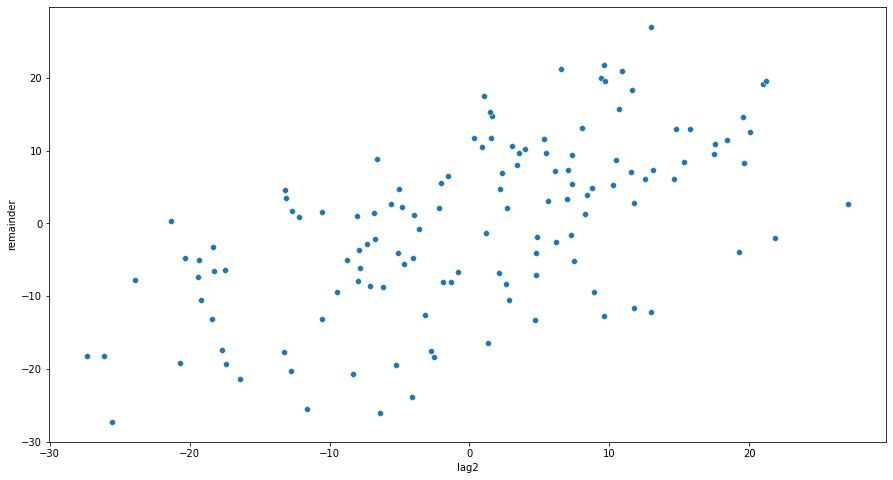

In [15]:
sns.scatterplot(x='lag2', y='remainder', data=df)

The relation between the remainder and lag2 might just be due to the relation between the remainder and lag1 and the relation between lag1 and lag2

In [16]:
round(df[['remainder', 'lag1', 'lag2']].corr(), 2)

,remainder,lag1,lag2
remainder,1.00,0.76,0.60
lag1,0.76,1.00,0.76
lag2,0.60,0.76,1.00


In [17]:
0.76 * 0.76

0.5776

**Correlation:**     
Relationship between variables. In the case of **auto-correlation**  we are looking at the same variable at different time steps in the same series. 

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})} {\sigma(y_t)\, \sigma( y_{t-h})} 
$$

**Covariance:**     
Think about it as variance of two variables with each other. 

[Covariance vs. correlation](https://www.mygreatlearning.com/blog/covariance-vs-correlation/#differencebetweencorrelationandcovariance)

Check out pd.cov(), pd.corr().

## 6.1) Partial Autocorrelation

One tool to find out how many lags we should include into our Autoregressive Model is to plot the Partial Autocorrelation between different lags. What is the Partial Autocorrelation?

$$
\delta_h = Corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

PACF is the correlation between $y_t$ and $y_{t−h}$, excluding the intermediate values ($y_{t-1}$, $y_{t-2}$, ...). 

They are basically nothing else than the coefficients in a linear regression if you included h lags.

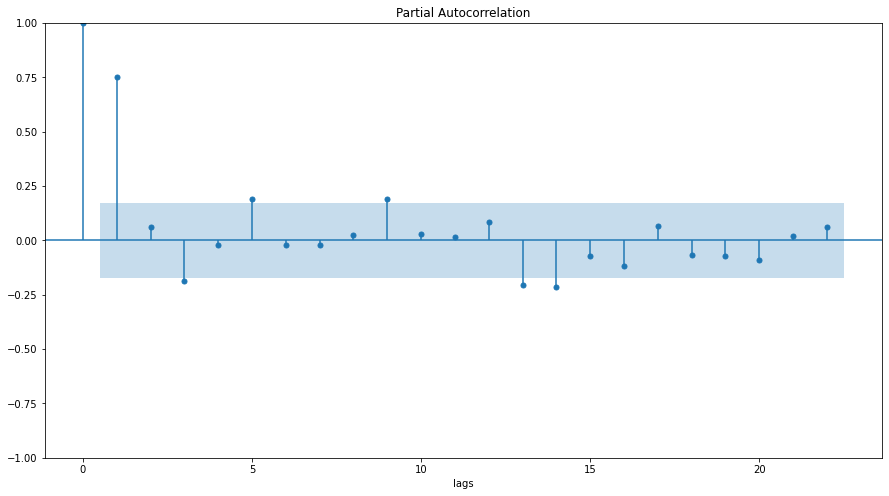

In [18]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
plot_pacf(df['remainder'], method='ywm')
plt.xlabel('lags');

**Box-Jenkins-Method:**

This method makes a statement about how to choose lags.

We will choose all lags until the first sharp drop in values. In this case we will have 1 lag. This is the point after which we know the correlation dropped significantly. 

## 6.2) Introducing statsmodels and ar_select_order

In [19]:
selected_order = ar_select_order(df['remainder'], maxlag = 12)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [20]:
selected_order.ar_lags

[1]

*statsmodels* also has an AutoReg which does a bit of the modelling for you.

In [21]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [22]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  131
Model:                     AutoReg(1)   Log Likelihood                -449.191
Method:               Conditional MLE   S.D. of innovations              7.663
Date:                Tue, 26 Apr 2022   AIC                            904.381
Time:                        17:27:28   BIC                            912.984
Sample:                    03-01-1949   HQIC                           907.877
                         - 12-01-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1976      0.672     -0.294      0.769      -1.515       1.120
remainder.L1     0.7563      0.057     13.369      0.000       0.645       0.867
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3223           +0.0000j            1.3223            0.0000
-----------------------------------------------------------------------------
"""

In [23]:
ar_model.predict()

1949-02-01          NaN
1949-03-01    13.034350
1949-04-01     5.471621
1949-05-01     7.052919
1949-06-01    -4.153670
                ...    
1959-08-01     3.414788
1959-09-01     6.508632
1959-10-01    -5.591734
1959-11-01    -7.379288
1959-12-01    -6.691767
Freq: MS, Length: 131, dtype: float64